## 1. Import Relevant Packages

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
import statsmodels.api as sm

## 2. Query CRSP Database

In [2]:
# We use monthly return data from common stocks (share code 10 and 11)

# OBS: Returns are pulled for exchcd = -2,-1, 0 to address the issue that stocks temp stopped trading. 
# Without these, the non-trading months will be tossed out in the output

# Source: WRDS
# -2 Halted by the NYSE or AMEX
# -1 Suspended by the NYSE, AMEX, or NASDAQ
# 0 Not Trading on NYSE, AMEX, or NASDAQ

# Stocks are from New York Stock Exchange (exchcd = 1)

In [3]:
# Change to NYSE_m1
crsp_m = pd.read_csv('Stocks.csv', low_memory=False)

crsp_m['date'] =  pd.to_datetime(crsp_m['date'])
crsp_m

,PERMNO,date,SHRCD,EXCHCD,SICCD,DLRET,PRC,RET,SHROUT
0,10000,1986-01-31,10,3,3990,NaN,-4.37500,C,3680.0
1,10000,1986-02-28,10,3,3990,NaN,-3.25000,-0.257143,3680.0
2,10000,1986-03-31,10,3,3990,NaN,-4.43750,0.365385,3680.0
3,10000,1986-04-30,10,3,3990,NaN,-4.00000,-0.098592,3793.0
4,10000,1986-05-30,10,3,3990,NaN,-3.10938,-0.222656,3793.0
...,...,...,...,...,...,...,...,...,...
3299489,93436,2020-08-31,11,3,9999,NaN,498.32001,0.741452,931809.0
3299490,93436,2020-09-30,11,3,9999,NaN,429.01001,-0.139087,948000.0
3299491,93436,2020-10-30,11,3,9999,NaN,388.04001,-0.095499,947901.0
3299492,93436,2020-11-30,11,3,9999,NaN,567.59998,0.462736,947901.0


In [4]:
# Make Python datetime format
crsp_m['date'] =  pd.to_datetime(crsp_m['date'])

# Sample starts in 1963
crsp_m = crsp_m[crsp_m['date'] >= '1963-01-31']

In [5]:
# Make all column names lower case
crsp_m.columns = crsp_m.columns.str.lower()

In [6]:
# Change variable format to int
crsp_m[['permno','shrcd','exchcd']]=\
    crsp_m[['permno','shrcd','exchcd']].astype(int)

In [7]:
# Forcing errors to become NaN to convert to int
crsp_m['ret'] = pd.to_numeric(crsp_m['ret'], errors='coerce')
crsp_m['dlret'] = pd.to_numeric(crsp_m['dlret'], errors='coerce') 

# Fill-in delisting return as last return
crsp_m['ret'] = crsp_m['ret'].fillna(value=crsp_m['dlret'])

# OBS!: fill in missing return with 0
crsp_m = crsp_m[crsp_m['ret'].notna()]
# crsp_m['ret']=[crsp_m['ret']].fillna(0)


In [8]:
# create log return for future usage
crsp_m['logret'] = np.log(1+crsp_m['ret'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
crsp_m.tail()

,permno,date,shrcd,exchcd,siccd,dlret,prc,ret,shrout,logret
3299489,93436,2020-08-31,11,3,9999,NaN,498.32001,0.741452,931809.0,0.554719
3299490,93436,2020-09-30,11,3,9999,NaN,429.01001,-0.139087,948000.0,-0.149762
3299491,93436,2020-10-30,11,3,9999,NaN,388.04001,-0.095499,947901.0,-0.100372
3299492,93436,2020-11-30,11,3,9999,NaN,567.59998,0.462736,947901.0,0.380309
3299493,93436,2020-12-31,11,3,9999,NaN,705.66998,0.243252,947901.0,0.217731


In [10]:
# Making dataframe w. market cap for later use
# OBS: FILL NA WITH 0 (should we forward-fill on the delisting date, and then delete all NaN's instead)
mkt_cap_df = crsp_m[['permno', 'date', 'prc', 'shrout']]
mkt_cap_df['prc'] = mkt_cap_df['prc'].fillna(0).astype(np.float32)
mkt_cap_df['shrout'] = mkt_cap_df['shrout'].fillna(0).astype(np.float32)

#mkt_cap_df = mkt_cap_df[mkt_cap_df['prc'].astype('int')]
#mkt_cap_df['prc'] = pd.to_numeric(mkt_cap_df['prc'], errors='coerce')
#mkt_cap_df['shrout'] = pd.to_numeric(mkt_cap_df['shrout'], errors='coerce')

# Calculating market cap
# OBS: MKT_CAP = prc and shares outstanding on the same day
# 'abs' is used as CRSP but '-' infront of value when no price is available and the bid/ask avg. is used instead 
mkt_cap_df['mkt_cap'] =  np.abs(mkt_cap_df['prc'] * mkt_cap_df['shrout'])

<ipython-input-10-2885ee0f88ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mkt_cap_df['prc'] = mkt_cap_df['prc'].fillna(0).astype(np.float32)
<ipython-input-10-2885ee0f88ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mkt_cap_df['shrout'] = mkt_cap_df['shrout'].fillna(0).astype(np.float32)
<ipython-input-10-2885ee0f88ad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [11]:
mkt_cap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201303 entries, 1 to 3299493
Data columns (total 5 columns):
 #   Column   Dtype         
---  ------   -----         
 0   permno   int64         
 1   date     datetime64[ns]
 2   prc      float32       
 3   shrout   float32       
 4   mkt_cap  float32       
dtypes: datetime64[ns](1), float32(3), int64(1)
memory usage: 109.9 MB


In [12]:
mkt_cap_df

,permno,date,prc,shrout,mkt_cap
1,10000,1986-02-28,-3.250000,3680.0,1.196000e+04
2,10000,1986-03-31,-4.437500,3680.0,1.633000e+04
3,10000,1986-04-30,-4.000000,3793.0,1.517200e+04
4,10000,1986-05-30,-3.109380,3793.0,1.179388e+04
5,10000,1986-06-30,-3.093750,3793.0,1.173459e+04
...,...,...,...,...,...
3299489,93436,2020-08-31,498.320007,931809.0,4.643391e+08
3299490,93436,2020-09-30,429.010010,948000.0,4.067015e+08
3299491,93436,2020-10-30,388.040009,947901.0,3.678235e+08
3299492,93436,2020-11-30,567.599976,947901.0,5.380286e+08


## 3. Calculate Formation Period Returns

In [36]:
# J = Formation Period Length
# Measures Based on Past (J) Month Compounded Returns
# We sort the permno, date, ret and logret by firstly company then date.

J = 11
sorted_crsp = crsp_m[['permno','date','ret','logret']].sort_values(['permno','date']).set_index('date')

# Calculating Rolling Cumulative Return in the Formation Period by summing log returns over the J month formation period
formation_df = sorted_crsp.groupby(['permno'])['logret'].rolling(J, min_periods=J).sum().reset_index()
formation_df = formation_df.rename(columns={'logret':'sumlogret'})

# reversing returns back to non-log
formation_df['cumret']=np.exp(formation_df['sumlogret'])-1


In [37]:
sorted_crsp = sorted_crsp.reset_index()

In [40]:
LSTM_input = pd.merge(formation_df[['permno', 'date', 'cumret']], sorted_crsp[['permno', 'date', 'ret']], on=['permno','date'], how='inner')

In [43]:
#LSTM_input.to_csv('LSTM_input.csv', index=True)

In [44]:
formation_df.tail()

,permno,date,sumlogret,cumret
3201298,93436,2020-08-31,2.336423,9.344169
3201299,93436,2020-09-30,1.918600,5.811416
3201300,93436,2020-10-30,1.771636,4.880464
3201301,93436,2020-11-30,1.914585,5.784121
3201302,93436,2020-12-31,1.690737,4.423475


## 4. Form 10 Momentum Portfolios
Momentum Rank (momr) = 1 for past losers
Momentum Rank (momr) = 10 for past winners

In [45]:
# Merging market cap df and formation df
formation_mc = pd.merge(mkt_cap_df[['permno','date','mkt_cap']], formation_df, on=['permno', 'date'], how='inner')
formation_mc.tail()

,permno,date,mkt_cap,sumlogret,cumret
3201298,93436,2020-08-31,464339072.0,2.336423,9.344169
3201299,93436,2020-09-30,406701504.0,1.918600,5.811416
3201300,93436,2020-10-30,367823520.0,1.771636,4.880464
3201301,93436,2020-11-30,538028608.0,1.914585,5.784121
3201302,93436,2020-12-31,668905280.0,1.690737,4.423475


In [46]:
formation_mc.count()

permno       3201303
date         3201303
mkt_cap      3201303
sumlogret    2956860
cumret       2956860
dtype: int64

In [47]:
formation_mc = formation_mc.dropna(axis=0, subset=['cumret'])

# For each date: Sorting stocks based on market cap
formation_mc = formation_mc.groupby('date').apply(lambda x: x.sort_values(['mkt_cap'], ascending = False)).reset_index(drop=True)

# For each date, select the stocks with the highest 500 market cap
# OBS: Note, this is the market cap at the end of the formation period (i.e. one month before we initiate our portfolios)
top500stocks = formation_mc.groupby('date').apply(lambda x: x.head(500)).reset_index(drop=True)

top500stocks.groupby('date').count()

,permno,mkt_cap,sumlogret,cumret
date,,,,
1963-11-29,500,500,500,500
1963-12-31,500,500,500,500
1964-01-31,500,500,500,500
1964-02-28,500,500,500,500
1964-03-31,500,500,500,500
...,...,...,...,...
2020-08-31,500,500,500,500
2020-09-30,500,500,500,500
2020-10-30,500,500,500,500


In [48]:
# For each date, ranking stocks into 1-10 portfolios based on cumret
# 1 = loser, 10 = winner portfolio top500stocks = top500stocks.groupby('date').apply(lambda x: x.sort_values(['cumret'], ascending = False)).reset_index(drop=True)
top500stocks['momr'] = top500stocks.groupby('date')['cumret'].transform(lambda x: pd.qcut(x, 10, labels=False))

# For visualization: Shift momr from 0-9 to 1-10 
top500stocks['momr']=1+top500stocks['momr']

In [49]:
###############################
##POTENTIALLY NEEDED FOR LSTM##
###############################

# Merging the momentum rank back into the umd_mkt_cap df
#top500stocks_LSTM = pd.merge(top500stocks[['permno', 'date', 'momr']], formation_mc, on=['permno', 'date'], how='outer')

# Filtering out companies that were never a part of the top 500 (and thus never got a rank)
#top500stocks_LSTM = top500stocks_LSTM.groupby('permno').filter(lambda x: x['momr'].mean() > 0)

# Total number of companies that were at some point in time a part of the top 500
#top500stocks_LSTM.groupby('permno').count()

# Note that we still have some nan-values for the months where a given firm is not in the top 500

In [50]:
# Average cumulative return for each portfolio
top500stocks.groupby('momr')['cumret'].mean()

momr
1.0    -0.237433
2.0    -0.087945
3.0    -0.012052
4.0     0.048547
5.0     0.105445
6.0     0.164214
7.0     0.230468
8.0     0.315358
9.0     0.447386
10.0    0.920698
Name: cumret, dtype: float64

In [51]:
# Shortening the df name
formation_df = top500stocks

# 5. Calculate Holding Period Return
Based on SAS code
K = Holding Period Length
Several key date variables:
hdate1 = start date of holding period
hdate2 = end date of holding period (determined by K)

In [52]:
# Then calculate hdate1 and hdate2 using medate

# K = Length of holding period
K = 1

# S= Length of skipping period
S = 1

formation_df['form_date'] = formation_df['date']
formation_df['medate'] = formation_df['date']+MonthEnd(0)
formation_df['hdate1']=formation_df['medate']+MonthBegin(1+S)
formation_df['hdate2']=formation_df['medate']+MonthEnd(K+S)
formation_df = formation_df[['permno', 'form_date','momr','hdate1','hdate2']]

In [53]:
# Checking start and end of holding period relative to end of formation date
formation_df = formation_df[formation_df['hdate2'] <= '2020-12-31']

formation_df.tail()

,permno,form_date,momr,hdate1,hdate2
341995,83534,2020-10-30,2.0,2020-12-01,2020-12-31
341996,27991,2020-10-30,4.0,2020-12-01,2020-12-31
341997,90925,2020-10-30,1.0,2020-12-01,2020-12-31
341998,82581,2020-10-30,3.0,2020-12-01,2020-12-31
341999,82759,2020-10-30,10.0,2020-12-01,2020-12-31


In [54]:
# Merging with old crsp_m dataframe to create holding period returns
holding_df = pd.merge(crsp_m[['permno','date','ret']], formation_df, on=['permno'], how='inner')

# Focusing on period that is higher than hdate1 and lower than hdate2
holding_df = holding_df[(holding_df['hdate1']<=holding_df['date']) & (holding_df['date']<=holding_df['hdate2'])]

# Rearrange the columns
holding_df = holding_df[['permno','form_date', 'momr', 'hdate1','hdate2', 'date', 'ret']]

In [55]:
# OBS: Fejl
holding_df.tail()

,permno,form_date,momr,hdate1,hdate2,date,ret
150900632,93436,2020-06-30,10.0,2020-08-01,2020-08-31,2020-08-31,0.741452
150900724,93436,2020-07-31,10.0,2020-09-01,2020-09-30,2020-09-30,-0.139087
150900816,93436,2020-08-31,10.0,2020-10-01,2020-10-31,2020-10-30,-0.095499
150900908,93436,2020-09-30,10.0,2020-11-01,2020-11-30,2020-11-30,0.462736
150901000,93436,2020-10-30,10.0,2020-12-01,2020-12-31,2020-12-31,0.243252


## 6. Calculate Portfolio Return

We use equally weighted (similar to most literature on momemntum, e.g., Jegadeesh and Titman, 1993, Blitz et al., 2011) At a given month, across all stocks within a momentum rank formed from a specific formation date

In [56]:
# For a given date, momentum ranking and portfolio formation date, we calculate the mean return
port = holding_df.groupby(['date','momr', 'form_date'])['ret'].mean().reset_index()

# OBS: Skip first 12 months of the sample (match with LSTM features)
start_yr = port.date.dt.year.min()+1
port = port.loc[port.date.dt.year>=start_yr]
port = port.sort_values(by=['date','momr'])

port.head(12)

,date,momr,form_date,ret
120,1965-01-29,1.0,1964-11-30,0.059927
121,1965-01-29,2.0,1964-11-30,0.046574
122,1965-01-29,3.0,1964-11-30,0.039957
123,1965-01-29,4.0,1964-11-30,0.050011
124,1965-01-29,5.0,1964-11-30,0.049491
125,1965-01-29,6.0,1964-11-30,0.041810
126,1965-01-29,7.0,1964-11-30,0.049477
127,1965-01-29,8.0,1964-11-30,0.038742
128,1965-01-29,9.0,1964-11-30,0.058285
129,1965-01-29,10.0,1964-11-30,0.058743


In [57]:
ewret_df = port

In [58]:
# Portfolio summary
ewret_df.groupby(['momr'])['ret'].describe()[['count','mean', 'std']].reset_index()

,momr,count,mean,std
0,1.0,672.0,0.006230,0.071998
1,2.0,672.0,0.008870,0.056247
2,3.0,672.0,0.009431,0.050363
3,4.0,672.0,0.009727,0.047123
4,5.0,672.0,0.008701,0.045463
5,6.0,672.0,0.009961,0.045159
6,7.0,672.0,0.010083,0.045426
7,8.0,672.0,0.010717,0.046871
8,9.0,672.0,0.012345,0.052290
9,10.0,672.0,0.014855,0.066970


## 7. Calculate Long Short Portfolio Returns
Each month, MOMR=10 (winners) portfolio - MOMR=1 (losers) portfolio

In [59]:
# Transpose portfolio layout to have columns as portfolio returns
ewret_t = ewret_df.pivot(index='date', columns='momr', values='ret')

# Add prefix port in front of each column
ewret_t = ewret_t.add_prefix('P')

In [60]:
# Creating long-short portfolio
ewret_t = ewret_t.rename(columns={'P1.0':'losers', 'P10.0':'winners'})
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers

ewret_t.head()

momr,losers,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,winners,long_short
date,,,,,,,,,,,
1965-01-29,0.059927,0.046574,0.039957,0.050011,0.049491,0.041810,0.049477,0.038742,0.058285,0.058743,-0.001183
1965-02-26,0.026006,0.025979,0.024902,0.008177,0.014978,0.019574,0.011225,0.025698,0.040547,0.036721,0.010716
1965-03-31,-0.008357,-0.010806,-0.011190,0.000873,-0.006451,-0.006137,-0.004631,-0.000229,-0.006912,0.002759,0.011116
1965-04-30,0.025547,0.020919,0.028975,0.031035,0.021549,0.014835,0.027929,0.031776,0.056279,0.054208,0.028661
1965-05-28,-0.013158,-0.018275,-0.008056,-0.004851,-0.002772,-0.016663,-0.004133,0.009026,-0.004871,-0.006570,0.006588


In [61]:
# Compute Long-Short Portfolio Cumulative Returns (for visualization)

ewret_t['cumret_winners']   = (1+ewret_t.winners).cumprod()-1
ewret_t['cumret_losers']    = (1+ewret_t.losers).cumprod()-1
ewret_t['cumret_long_short']= (1+ewret_t.long_short).cumprod()-1

## 8. Portfolio statistics

In [62]:
# Mean 
mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()

# Standard deviation
mom_std = ewret_t[['winners', 'losers', 'long_short']].std().to_frame()
mom_std = mom_std.rename(columns={0:'std'}).reset_index()

print(mom_mean)
print('________________________')
print(mom_std)

         momr      mean
0     winners  0.014855
1      losers  0.006230
2  long_short  0.008625
________________________
         momr       std
0     winners  0.066970
1      losers  0.071998
2  long_short  0.069106


In [63]:
# T-Value and P-Value
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'],0.0)).to_frame().T
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'],0.0)).to_frame().T
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'],0.0)).to_frame().T

t_losers['momr']='losers'
t_winners['momr']='winners'
t_long_short['momr']='long_short'

In [64]:
t_output =pd.concat([t_winners, t_losers, t_long_short])\
    .rename(columns={0:'t-stat', 1:'p-value'})

# Combine mean, t and p and format output
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format)
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format)
mom_output['p-value'] = mom_output['p-value'].map('{:.3f}'.format)

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          momr   mean t-stat p-value
0     winners  1.49%   5.75   0.000
1      losers  0.62%   2.24   0.025
2  long_short  0.86%   3.24   0.001


## 9. Plotting the Return Series

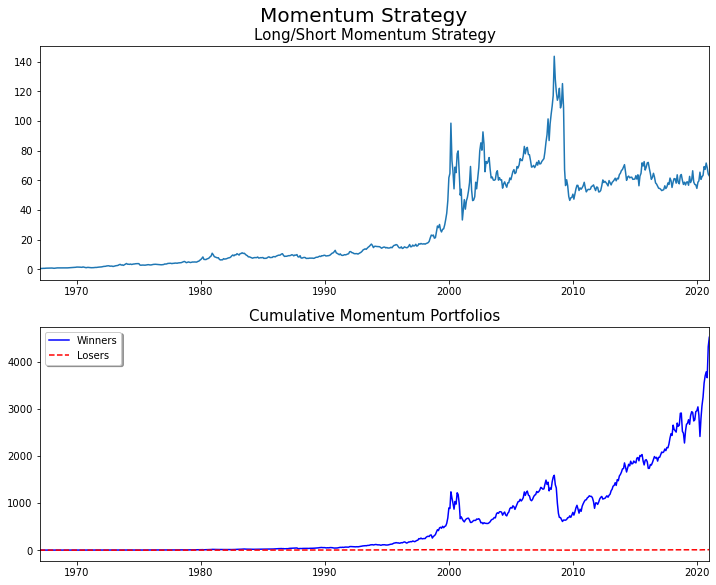

In [65]:
plt.figure(figsize=(12,9))
plt.suptitle('Momentum Strategy', fontsize=20)
ax1 = plt.subplot(211)
ax1.set_title('Long/Short Momentum Strategy', fontsize=15)
ax1.set_xlim([dt.datetime(1967,1,1), dt.datetime(2020,12,31)])
ax1.plot(ewret_t['cumret_long_short'])
ax2 = plt.subplot(212)
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15)
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--')
ax2.set_xlim([dt.datetime(1967,1,1), dt.datetime(2020,12,31)])
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)
plt.subplots_adjust(top=0.92, hspace=0.2)

### Testing with FF MOM

In [66]:
# Obtaining Fama-French MOM factors
ff_mom = pd.read_csv('FF_mom.csv', skiprows = 12, nrows=1128, index_col = 0)

# Setting monthly index
ff_mom.index = pd.to_datetime(ff_mom.index, format= '%Y%m')
ff_mom.index = ff_mom.index.to_period('M')

# Renaming column
ff_mom.rename(columns={ ff_mom.columns[0]: "mom" }, inplace = True)

In [67]:
# Set monthly index for MOM strategy
mom = ewret_t
mom.index = mom.index.to_period('M')

In [68]:
# Creating dataframe
test_df = pd.merge(mom['long_short'], ff_mom, left_index=True, right_index=True)

In [69]:
# Correlation 
test_df['long_short'].corr(test_df['mom'])

0.8896617879697284

## Creating universe for LSTM

In [70]:
universe = formation_df.rename(columns={'hdate2':'date'})
universe = universe.set_index(universe['date'], inplace=False)

In [71]:
universe = universe[['permno']] 
universe = universe.sort_values(by=['date','permno'])

In [72]:
universe

,permno
date,
1964-01-31,10006
1964-01-31,10102
1964-01-31,10137
1964-01-31,10145
1964-01-31,10153
...,...
2020-12-31,93096
2020-12-31,93132
2020-12-31,93246


In [73]:
# Saving file as CSV for the LSTM model
universe.to_csv('universe.csv', index=True)

In [74]:
# for dt, permno in universe.groupby('date'):
#     print(permno)

## LSTM PREP

In [75]:
#LSTM_data = holding_df
#LSTM_data.groupby('permno').count()

In [76]:
#formation_mc = formation_mc.rename(columns={"date": "form_date"})
#formation_mc.groupby('permno').count()

In [77]:
# Including cumreturn and merging ong formation date
#LSTM_data_m = pd.merge(LSTM_data, formation_mc[['permno','form_date','cumret']], on=['permno', 'form_date'], how='left')
#LSTM_data_m

In [78]:
#LSTM_data_m = LSTM_data_m.set_index(LSTM_data_m['hdate2'], drop=False, inplace=False)
#LSTM_data_m

In [79]:
#LSTM_data_m = LSTM_data_m[['permno', 'momr', 'ret', 'cumret']]
#LSTM_data_m

In [80]:
# Saving file as CSV for the LSTM model
#LSTM_data_m.to_csv('LSTM_data_m.csv', index=True)